In [1]:
import os
if not os.environ.get("PREAMBLE_RUN", False): 
    %run -i '../preamble.py' 2

In [2]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import src.constants as const
from src.rate_tfidf_threshold import rate_tfidf_threshold

## 1. Sample items that tf-idf would reject at different thresholds

In [2]:
# import preprocessed data and inspect
df = pd.read_parquet(const.PATH_ALL_SPEECHES)
df.head()

,Unnamed: 0,speaker,text,date,agenda,speechnumber,procedure_ID,partyfacts_ID,period,chair,...,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,migration_prob
1,1,Daniel Freund,"Frau Präsidentin, liebe Kolleginnen und Kolleg...",2024-04-25,2. Interinstitutional Body for Ethical Standar...,2,,6403.0,9,False,...,0.000154,0.000154,0.014070,0.000154,0.000154,0.000154,0.000154,0.041970,0.000154,0.000154
3,3,Sven Simon,"Madam President, colleagues, this last day of ...",2024-04-25,2. Interinstitutional Body for Ethical Standar...,4,,6398.0,9,False,...,0.000397,0.000397,0.000397,0.000397,0.000397,0.000397,0.000397,0.000397,0.000397,0.000397
4,4,Gabriele Bischoff,"Frau Präsidentin, werte Kommission, Kolleginne...",2024-04-25,2. Interinstitutional Body for Ethical Standar...,5,,6399.0,9,False,...,0.000200,0.000200,0.000200,0.009344,0.000200,0.000200,0.000200,0.000200,0.000200,0.000200
5,5,Gilles Boyer,"Madame la Présidente, Monsieur le Commissaire,...",2024-04-25,2. Interinstitutional Body for Ethical Standar...,6,,6401.0,9,False,...,0.000433,0.000433,0.000433,0.000433,0.000433,0.071834,0.000433,0.000433,0.000433,0.000433
6,6,Heidi Hautala,"Madam President, we really have to thank Danie...",2024-04-25,2. Interinstitutional Body for Ethical Standar...,7,,6403.0,9,False,...,0.000472,0.000472,0.098843,0.000472,0.000472,0.000472,0.000472,0.000472,0.000472,0.000472


In [3]:
# obtain manual ratings for TF-IDF threshold
score_range=(5,10) # a sensible threshold should be between those values
n_samples=100 # number of samples to rate
min_df=2 # ignore terms that appear in less than min_df documents
max_df=0.99 # ignore terms that appear in more than max_df fraction of documents
ratings = rate_tfidf_threshold(df, score_range=score_range, n_samples=n_samples, min_df=min_df, max_df=max_df)

Tokenizing sentences...
Found 236812 first sentences
Fitting TF-IDF vectorizer...
Calculating TF-IDF scores...

Starting manual rating: 100 sentences



Output()

Button(description='1: Remove', style=ButtonStyle())

Button(description='0: Substantive', style=ButtonStyle())

In [4]:
# save ratings
rater = "quirin" # ratings are done two times by different raters
ratings.to_csv(f"tf_idf_ratings_{rater}.csv")

## 2. Combine ratings and find appropriate threshold

In [12]:
ratings_jakob = pd.read_csv("tf_idf_ratings_Jakob.csv")
ratings_quirin = pd.read_csv("tf_idf_ratings_Quirin.csv")
ratings_both = [ratings_jakob, ratings_quirin]

In [13]:
desired_accuracy = 0.95 # 95% of rejected sentences by tf-idf should indeed be non-informative 

Average rejection rate by rater 0: 0.91
Average rejection rate by rater 1: 0.86
Average rejection rate of both raters combined: 0.89


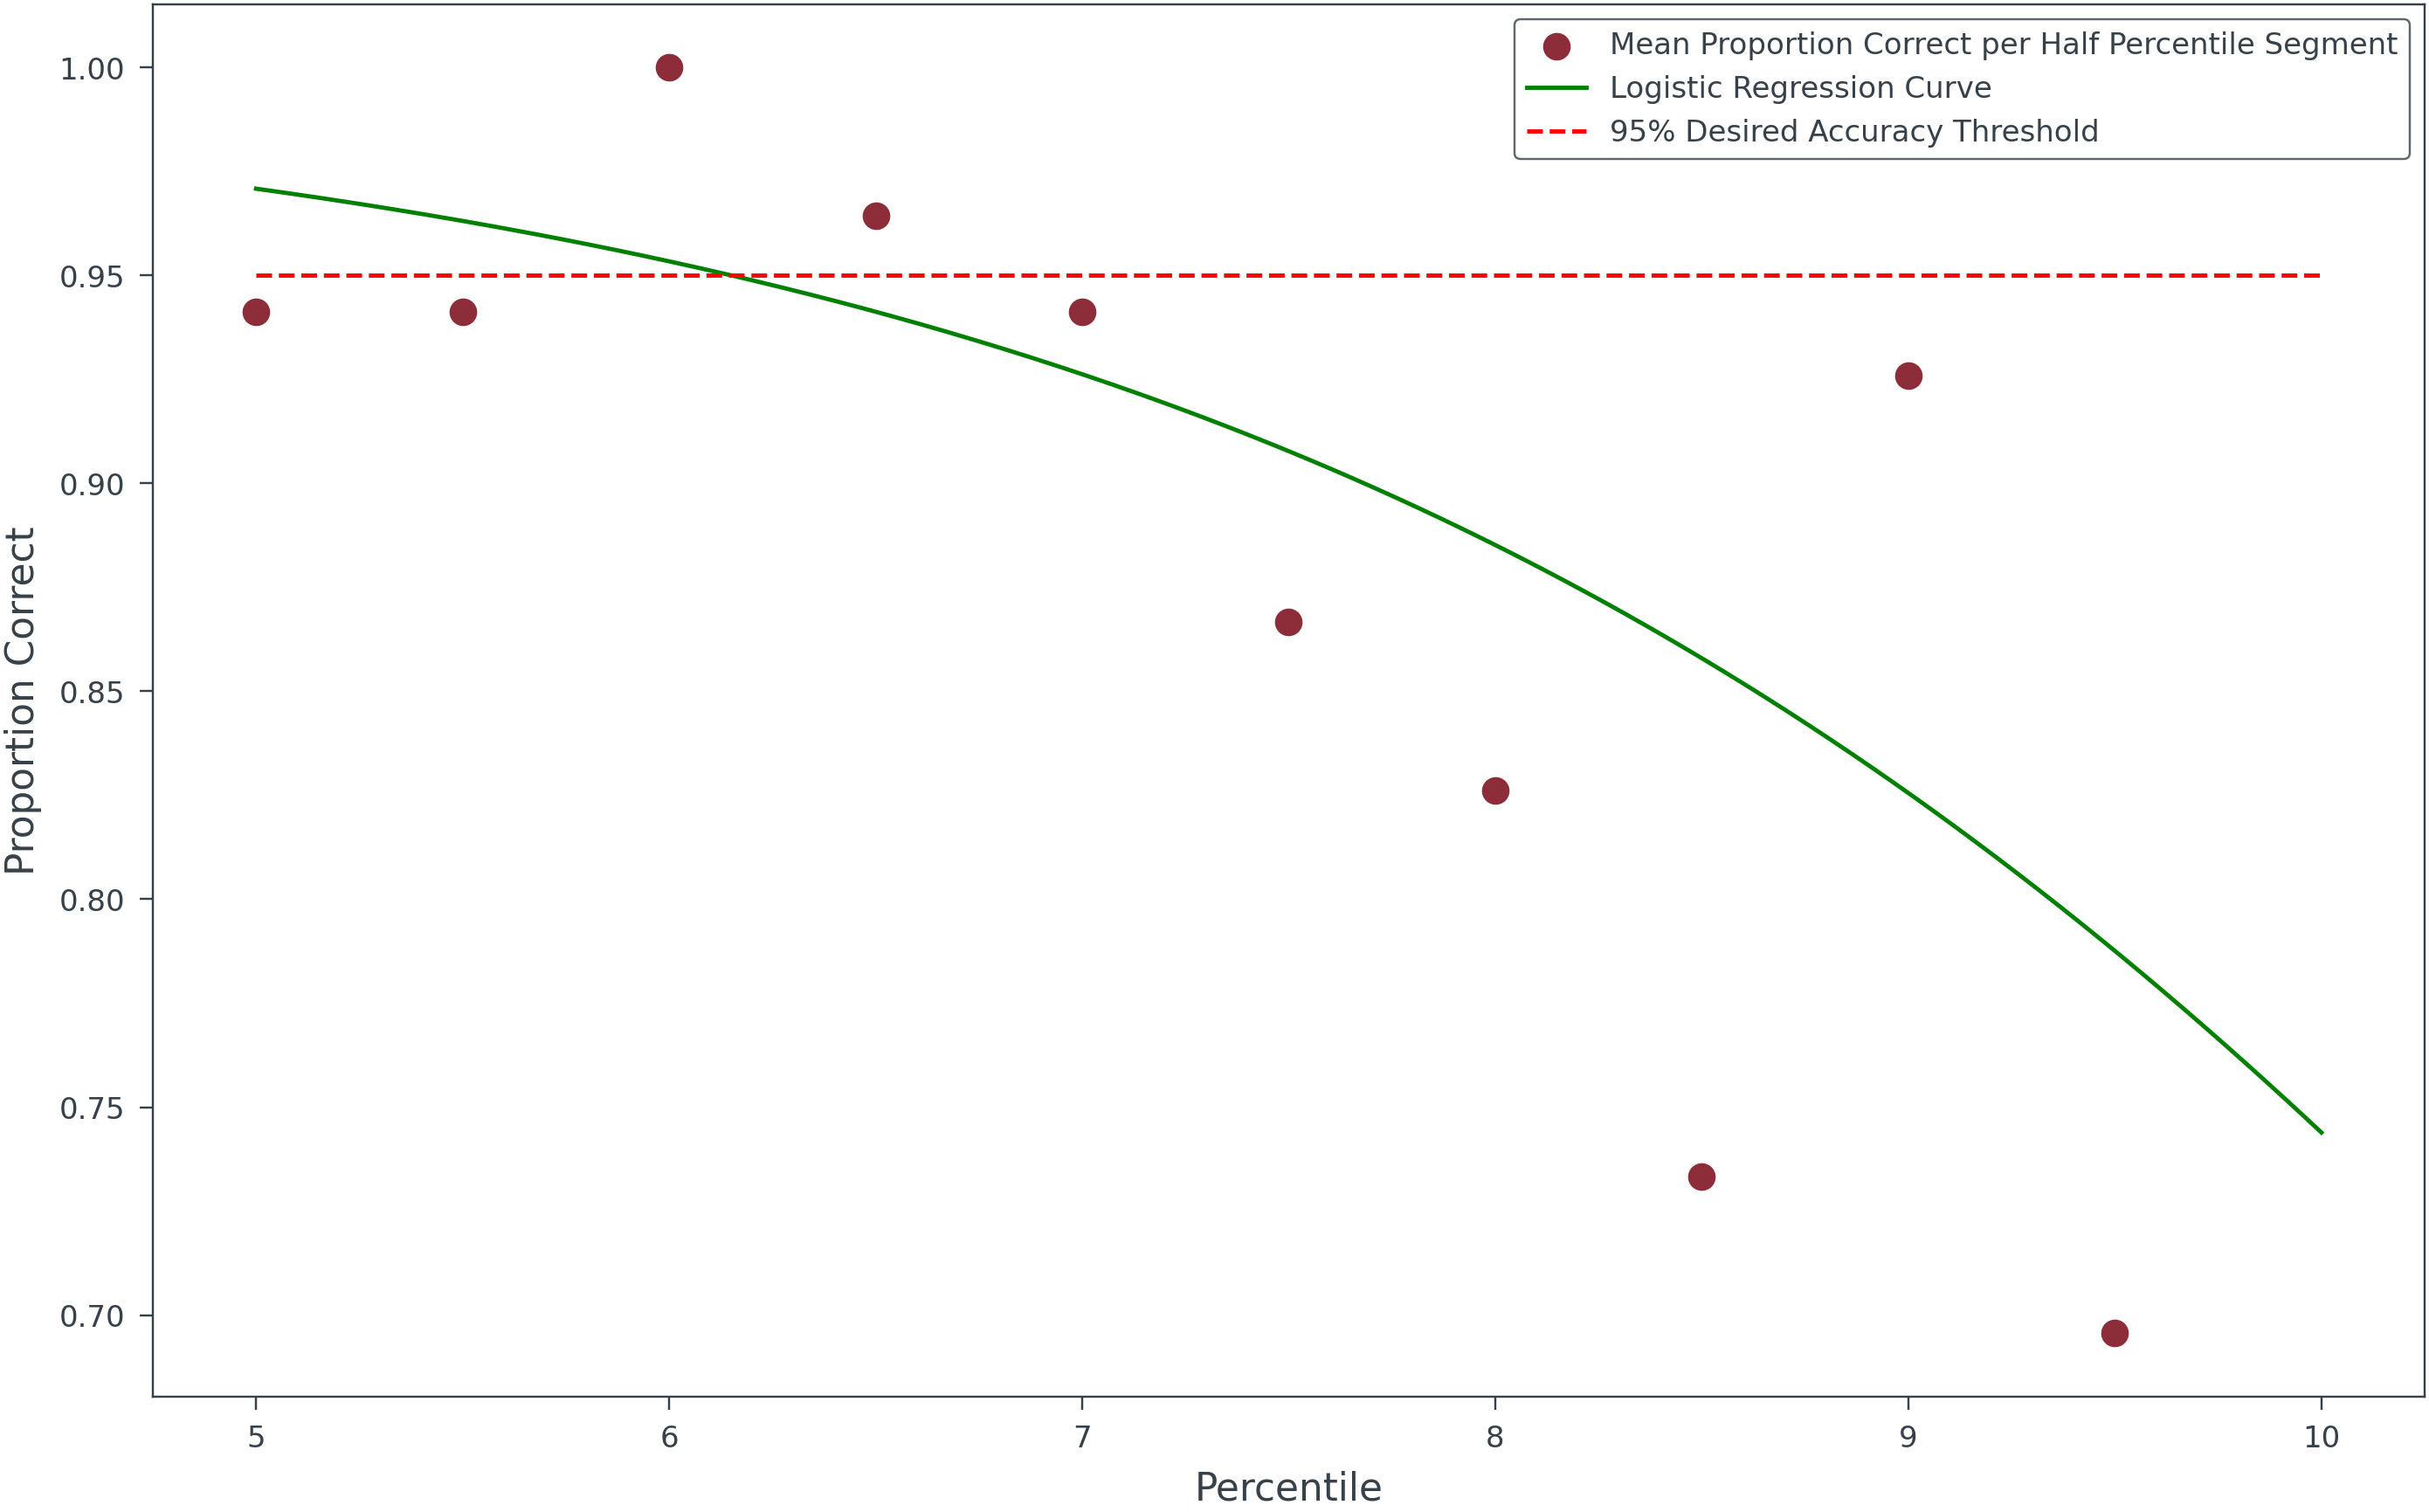

Percentile threshold for 95.0% accuracy: 6.151912327799928


In [14]:
for i, ratings in enumerate(ratings_both):
    # print average rejection rate
    avg_rejection = ratings['rating'].mean()
    print(f"Average rejection rate by rater {i}: {avg_rejection:.2f}")

# combine ratings
ratings_combined = pd.concat(ratings_both, ignore_index=True)

# print average rejection rate of both raters combined
avg_rejection = ratings_combined['rating'].mean()
print(f"Average rejection rate of both raters combined: {avg_rejection:.2f}")

# calculate proportion correct per half percentile segment (for plotting)
stepsize = 0.5
percentile_segments = np.arange(score_range[0], score_range[1] + 1, stepsize)
segment_n = len(percentile_segments)
proportion_correct = []
for i in range(len(percentile_segments) - 1):
    lower_bound = percentile_segments[i]
    upper_bound = percentile_segments[i+1]
    segment_ratings = ratings_combined[(ratings_combined['percentile'] >= lower_bound) & (ratings_combined['percentile'] < upper_bound)]
    if len(segment_ratings) > 0:
        prop_correct = segment_ratings['rating'].mean()
    else:
        prop_correct = np.nan
    proportion_correct.append(prop_correct)

# fit logistic regression model
ratings_combined['rating'] = ratings_combined['rating'].astype(int)
X = np.array(ratings_combined["percentile"]).reshape(-1, 1)
y = np.array(ratings_combined["rating"]).reshape(-1, 1)
log_model = LogisticRegression()
log_model.fit(X, y.ravel())

# plot logistic regression curve
plt.figure(figsize=(8,5))
plt.scatter(percentile_segments[:-1], proportion_correct, label='Mean Proportion Correct per Half Percentile Segment')
x_range = np.linspace(score_range[0], score_range[1], 300).reshape(-1, 1)
y_prob = log_model.predict_proba(x_range)[:, 1]
plt.plot(x_range, y_prob, color='green', label='Logistic Regression Curve')
plt.hlines(y=desired_accuracy, xmin=score_range[0], xmax=score_range[1], colors='red', linestyles='dashed', label='95% Desired Accuracy Threshold')
plt.xlabel('Percentile')
plt.ylabel('Proportion Correct')
plt.legend()
plt.show()

# Calculate the percentile threshold for the desired accuracy
logit_threshold = np.log(desired_accuracy / (1 - desired_accuracy))
coef = log_model.coef_[0][0]
intercept = log_model.intercept_[0]
percentile_threshold = (logit_threshold - intercept) / coef
print(f"Percentile threshold for {desired_accuracy*100}% accuracy: {percentile_threshold}")
